In [2]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-detection


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.callbacks import EarlyStopping
sns.set()

2025-05-03 17:49:52.920607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746294593.175464    2309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746294593.242604    2309 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
os.listdir('/kaggle/input/face-mask-detection')

['annotations', 'images']

In [5]:
images = []
for i in os.listdir('/kaggle/input/face-mask-detection/images'):
    path = os.path.join('/kaggle/input/face-mask-detection/images', i)
    img = cv2.imread(path)
    if img is None:
        print(path)
    else:
        resized_img = cv2.resize(img, (80, 80))
        images.append(resized_img)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


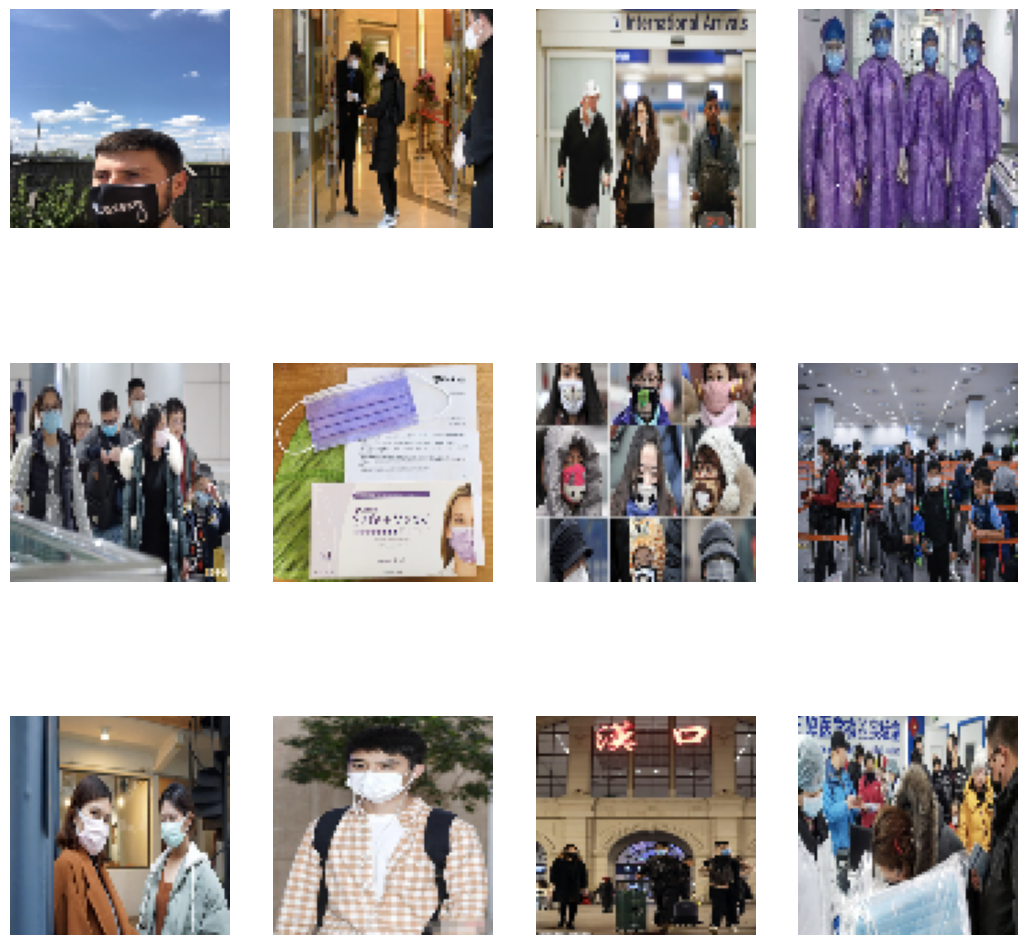

In [6]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

In [7]:
print(f'Size of all images:', len(images))

Size of all images: 853


In [8]:
train_imgs = images[:800]
test_imgs = images[800:]

In [9]:
X_train, X_valid = train_test_split(train_imgs, test_size = 0.1, random_state = 101)

In [10]:
X_train_np = np.array(X_train)
X_train_scaled = X_train_np / 255

In [11]:
X_valid_np = np.array(X_valid)
X_valid_scaled = X_valid_np / 255

In [12]:
def add_noise(img):
    mean = 0
    std_dev_original = 20
    std_dev_scaled = std_dev_original / 255
    gaussian_noise = np.random.normal(mean, std_dev_scaled, img.shape)
    noisy_img = img + gaussian_noise
    return noisy_img

In [13]:
noisy_train = add_noise(X_train_scaled)

In [14]:
noisy_valid = add_noise(X_valid_scaled)

In [15]:
len(noisy_train)

720

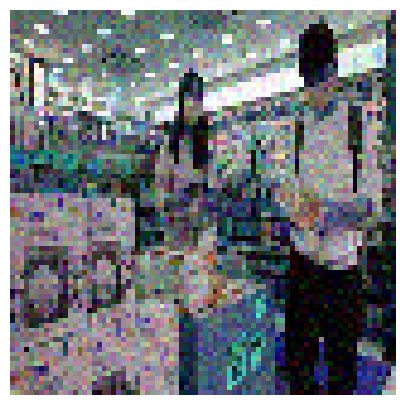

In [16]:
plt.figure(figsize = (7, 5))
plt.imshow(noisy_train[0])
plt.axis('off')
plt.show()

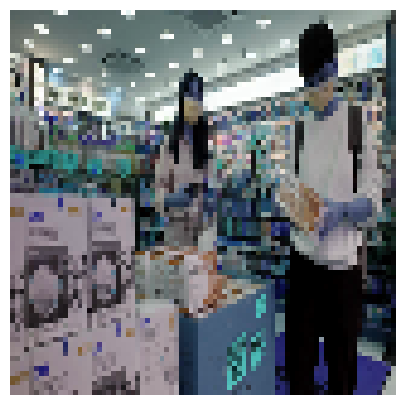

In [17]:
plt.figure(figsize = (7, 5))
plt.imshow(X_train_scaled[0])
plt.axis('off')
plt.show()

In [18]:
def data_preparation(data):
    data2 = tf.data.Dataset.from_tensor_slices(data)
    return data2.map(lambda x: (x, x)).batch(32)

In [19]:
train_ds = data_preparation(noisy_train)

I0000 00:00:1746294623.847906    2309 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746294623.848630    2309 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [20]:
valid_ds = data_preparation(noisy_valid)

In [21]:
test_imgs_np = np.array(test_imgs)
test_imgs_scaled = test_imgs_np / 255

In [22]:
inputs = Input(shape = (80, 80, 3))
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
encoded = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)
outputs = Conv2D(3, (3, 3), padding = 'same', activation = 'relu')(x)

In [23]:
autoencoder = Model(inputs, outputs)

In [24]:
autoencoder.compile(
    optimizer = 'adam',
    loss = 'mse'
)

In [25]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)

In [26]:
history = autoencoder.fit(train_ds, validation_data = valid_ds, epochs = 300, callbacks = [early_stopping])

Epoch 1/300


I0000 00:00:1746294628.786174    2355 service.cc:148] XLA service 0x7f243400da70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746294628.787143    2355 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746294628.787168    2355 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746294629.166227    2355 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/23 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2228

I0000 00:00:1746294633.538733    2355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 265ms/step - loss: 0.1568 - val_loss: 0.0486
Epoch 2/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0476 - val_loss: 0.0364
Epoch 3/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0368 - val_loss: 0.0325
Epoch 4/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0356 - val_loss: 0.0301
Epoch 5/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0311 - val_loss: 0.0280
Epoch 6/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0293 - val_loss: 0.0272
Epoch 7/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0286 - val_loss: 0.0264
Epoch 8/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0279 - val_loss: 0.0261
Epoch 9/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0273 - val_loss: 0.0254
Epoch 10/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0266 - val_loss: 0.0249
Epoch 11/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0262 - val_loss: 0.0248
Epoch 12/300
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0

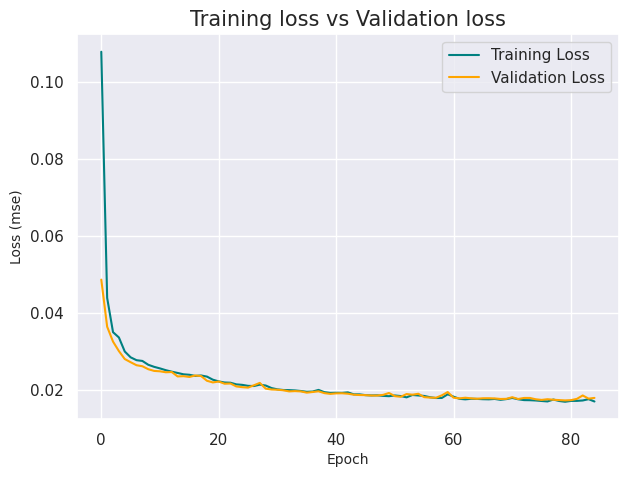

In [27]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss (mse)', fontsize = 10)
plt.legend()
plt.show()

In [28]:
test1 = add_noise(test_imgs_scaled[0])

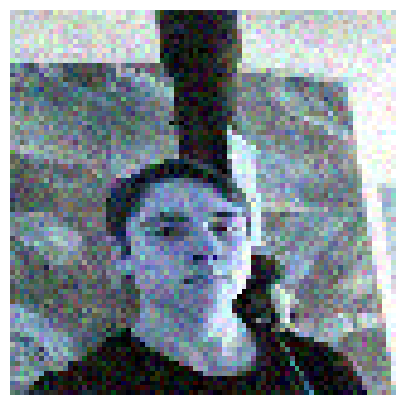

In [29]:
plt.figure(figsize = (7, 5))
plt.imshow(test1)
plt.axis('off')
plt.show()

In [30]:
test_1 = np.expand_dims(test1, axis = 0)

In [31]:
test_1.shape

(1, 80, 80, 3)

In [32]:
t_p1 = autoencoder.predict(test_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


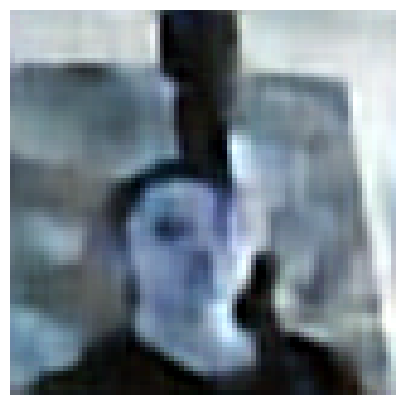

In [33]:
plt.figure(figsize = (7, 5))
plt.imshow(t_p1[0])
plt.axis('off')
plt.show()

In [34]:
path = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification-v2


In [35]:
os.listdir('/kaggle/input/garbage-classification-v2')

['garbage-dataset']

In [36]:
os.listdir('/kaggle/input/garbage-classification-v2/garbage-dataset')

['metal',
 'glass',
 'biological',
 'paper',
 'battery',
 'trash',
 'cardboard',
 'shoes',
 'clothes',
 'plastic']

In [37]:
images = []
for i in os.listdir('/kaggle/input/garbage-classification-v2/garbage-dataset'):
    for j in os.listdir(os.path.join('/kaggle/input/garbage-classification-v2/garbage-dataset', i)):
        path = os.path.join('/kaggle/input/garbage-classification-v2/garbage-dataset', i, j)
        img = cv2.imread(path)
        if img is None:
            print(path)
        else:
            resized_img = cv2.resize(img, (120, 120))
            images.append(resized_img)

In [38]:
X_train, X_test = train_test_split(images, test_size = 0.3, random_state = 101)

In [39]:
X_test_n, X_valid = train_test_split(X_test, test_size = 0.1, random_state = 101)

In [40]:
X_train_np = np.array(X_train)
X_train_scaled = X_train_np / 255

In [41]:
X_test_np = np.array(X_test_n)
X_test_scaled = X_test_np / 255

In [42]:
X_valid_np = np.array(X_valid)
X_valid_scaled = X_valid_np / 255

In [43]:
train_no = add_noise(X_train_scaled)

In [44]:
valid_no = add_noise(X_valid_scaled)

In [45]:
train_ds_n = data_preparation(train_no)

In [46]:
valid_ds_n = data_preparation(valid_no)

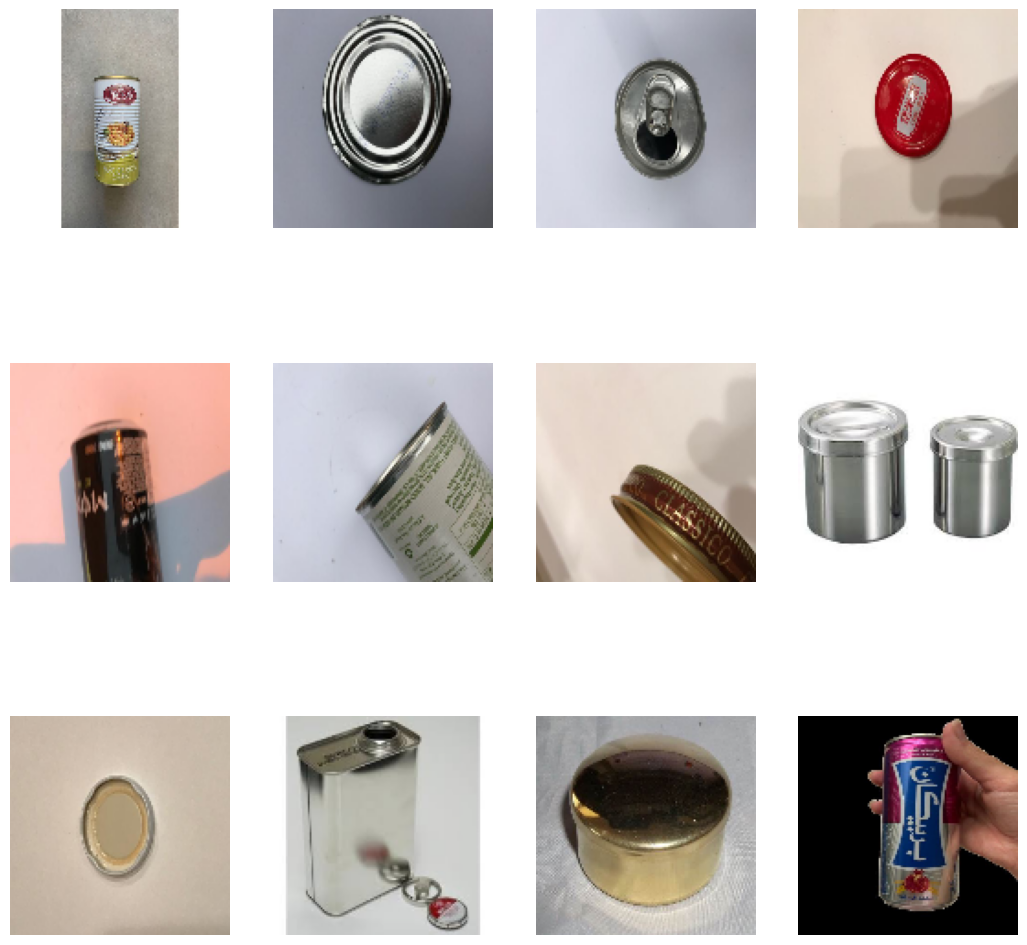

In [47]:
plt.figure(figsize = (13, 13))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')

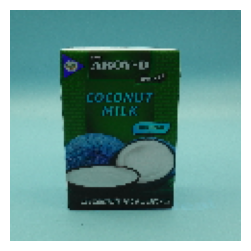

In [48]:
plt.figure(figsize = (5, 3))
plt.imshow(X_train_scaled[0])
plt.axis('off')
plt.show()

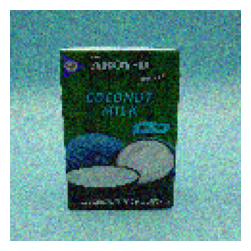

In [49]:
plt.figure(figsize = (5, 3))
plt.imshow(train_no[0])
plt.axis('off')
plt.show()

In [50]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 5)

In [51]:
history2 = autoencoder.fit(train_ds_n, validation_data = valid_ds_n, epochs = 300, callbacks = [early_stopping2])

Epoch 1/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - loss: 0.0227 - val_loss: 0.0119
Epoch 2/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 3/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 4/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 5/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 6/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0104 - val_loss: 0.0104
Epoch 7/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 8/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0102 - val_loss: 0.0105
Epoch 9/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0103 - val_loss: 0.0103
Epoch 10/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 11/300
433/433 ━━━━━━━━━━━━━━━━━━━━ 24s 56ms/step - loss: 0.0101 - val_loss: 0.0103
Epoch 12/300
433/43

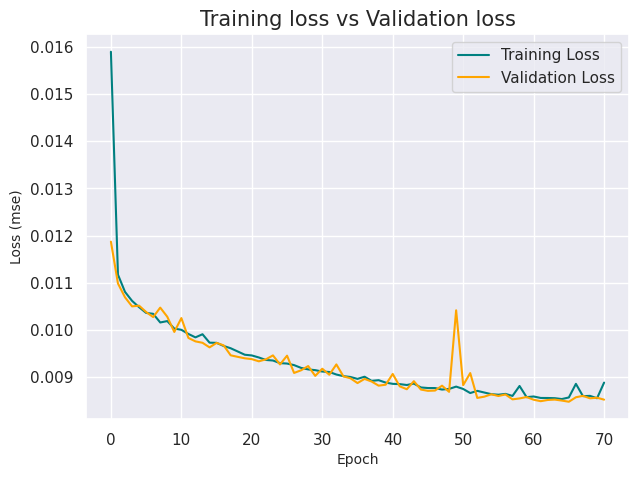

In [52]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'teal')
plt.plot(history2.history['val_loss'], label = 'Validation Loss', color = 'orange')
plt.title('Training loss vs Validation loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss (mse)', fontsize = 10)
plt.legend()
plt.show()

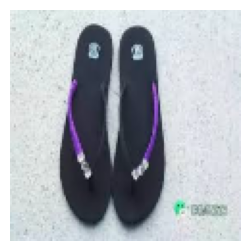

In [53]:
plt.figure(figsize = (5, 3))
plt.imshow(X_test_scaled[0])
plt.axis('off')
plt.show()

In [54]:
test_noise = add_noise(X_test_scaled[0])

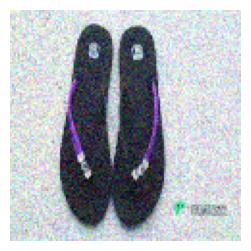

In [55]:
plt.figure(figsize = (5, 3))
plt.imshow(test_noise)
plt.axis('off')
plt.show()

In [56]:
test_noise_im = np.expand_dims(test_noise, axis = 0)

In [57]:
test_noise_im.shape

(1, 120, 120, 3)

In [58]:
pred = autoencoder.predict(test_noise_im)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


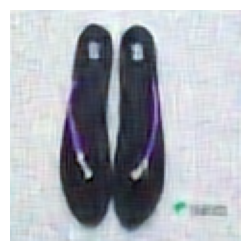

In [59]:
plt.figure(figsize = (5, 3))
plt.imshow(pred[0])
plt.axis('off')
plt.show()